In [1]:
import torch
import numpy as np
import mediapy
from scipy.io import savemat
import argparse
from tqdm import tqdm
from aux.tracking_viz import generate_frame_image_cv
from src.new_queries import add_new_tracks

import matplotlib.pyplot as plt
from src.factorization import marques_factorization
import rerun as rr
from src.mat_compl import alternating_matrix_completion

%load_ext autoreload
%autoreload 2

# add tapnext to pythonpath
import sys
sys.path.append("/home/manuelf/tapnet")
from tapnet.tapnext.tapnext_torch import TAPNext # type: ignore
from tapnet.tapnext.tapnext_torch_utils import restore_model_from_jax_checkpoint # type: ignore

def init_tapnext(device):

  tapnext = TAPNext(image_size=(256, 256)).to(device)

  #set model to eval, not backprop
  tapnext.eval()
  for p in tapnext.parameters():
    p.requires_grad = False

  tapnext = restore_model_from_jax_checkpoint(tapnext, "/home/manuelf/tapnet/tapnet/tapnext/tapnet/checkpoints/bootstapnext_ckpt.npz")

  return tapnext




/home/manuelf/miniconda3/envs/trackers/lib/python3.11/site-packages/torch/_export/utils.py:415: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _register_pytree_node(


In [2]:
import cv2 as cv

model_video_size = (256, 256)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cuda:0"
video = torch.tensor(mediapy.read_video("../mast3r/images_in/bordalo_2s_reverse.mp4"))  # downsample 
#video = torch.tensor(mediapy.read_video("../mast3r/images_in/inox.mp4"))  # downsample 

video = ((video / 255) - 0.5) * 2 # normalize to [-1, 1]
video_resized = mediapy.resize_video(video, model_video_size).astype(np.float32)

tapnext = init_tapnext(device)

In [ ]:

# Design the query points array in the original video size
step = 40
ys, xs = np.meshgrid(np.linspace(8, video[0].shape[0]-step, step), np.linspace(8, video[0].shape[1]-step, step))
query_points_initial = torch.tensor(
    np.stack(
    [np.zeros(len(xs.flatten())), xs.flatten(), ys.flatten()], axis=1
)[None],dtype=torch.float32).to(device)

im = cv.resize( cv.cvtColor(np.array(video[0]*255).copy().astype(np.uint8), cv.COLOR_RGB2BGR), 
               tuple(np.flip(np.array(video[0].shape[0:2]))*5) ) # Copy the first frame for visualization

#write text with opencv
for i in range(query_points_initial.shape[1]):
    im = cv.putText(img=im, text=str(i), org=(int(query_points_initial[0, i, 1].item()*5), int(query_points_initial[0, i, 2].item()*5)),
                     fontFace=cv.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)
    
cv.imwrite("query_points_initial.png", im)

#resize the querys points to the model size
query_points_initial[0, :, 1:3] /= torch.tensor([video[0].shape[1] / model_video_size[0], video[0].shape[0] / model_video_size[1]]).to(device)

#creata tensors for the video information
video_tensor_original = torch.cat([torch.tensor(frame).unsqueeze(0) for frame in video]).unsqueeze(0) # 1, time, H, W, 3
video_tensor_resized = torch.cat([torch.tensor(frame).unsqueeze(0) for frame in video_resized]).unsqueeze(0).to(device) # 1, time, H, W, 3

In [15]:

# INFERENCE
next_track_id = 0  # unique ID for every track
track_histories = {}  # track_id -> list of (frame_index, (x, y)) or None
active_tracks = {}  # current_idx -> track_id (used during current step)

with torch.no_grad():
  with torch.amp.autocast('cuda', dtype=torch.float32, enabled=True):
    
    tracks, tracks_logits, visible_logits, tracking_state = tapnext(video=video_tensor_resized[:, :1], query_points=query_points_initial)

    num_feats = tracks.shape[2]
    for i in range(num_feats):
        track_id = next_track_id
        next_track_id += 1
        active_tracks[i] = track_id
        track_histories[track_id] = [(0, tracks[0, 0, i, :2].cpu())]  # frame 0 position

    for k in tqdm(range(1, video_tensor_resized.shape[1])):

        tracks_step, tracks_logits_step, visible_logits_step, tracking_state = tapnext(
            video=video_tensor_resized[:, k:k + 1],
            state=tracking_state)
        
        # trakcs_step sai sempre bem 

        visible = (visible_logits_step.squeeze() > 0).cpu()
        for i, track_tensor in enumerate(tracks_step[0, 0]):
            track_id = active_tracks.get(i, None)
            if track_id is not None:
                if visible[i]:
                    track_histories[track_id].append((k, track_tensor[:2].cpu()))
                else:
                    track_histories[track_id].append((k, None))  # Not visible

        # New feature detection
        new_tracks = add_new_tracks(tracks_step, query_points_initial)
        
        #if 0:
        if new_tracks is not None and new_tracks.shape[1] > 60:
            print(f"Adding new tracks: {new_tracks.shape[1]}")

            new_tracks[0, :, 0] = 0  # set time to 0 for tapnext reinit

            # retain visible active tracks from previous step
            retained_indices = [i for i, v in enumerate(visible) if v]
            retained_ids = [active_tracks[i] for i in retained_indices]

            retained_tracks = tracks_step[0, 0, retained_indices].unsqueeze(0)
            zero_time = torch.zeros((1, len(retained_indices), 1)).to(retained_tracks.device)
            retained_tracks = torch.cat([zero_time, retained_tracks], dim=2)

            concat_tracks = torch.cat([retained_tracks, new_tracks.to(device)], dim=1)

            tracks_step, tracks_logits_step, visible_logits_step, tracking_state = tapnext(
                video=video_tensor_resized[:, k].unsqueeze(0),
                query_points=concat_tracks)

            # update active_tracks dict
            active_tracks = {}
            for i, id in enumerate(retained_ids):
                active_tracks[i] = id  # preserve old IDs

            new_start = len(retained_ids)
            visible = (visible_logits_step.squeeze() > 0).cpu()
            for i in range(new_tracks.shape[1]):
                track_id = next_track_id
                next_track_id += 1
                active_tracks[new_start + i] = track_id
                if visible[new_start + i]:
                    # Only add if the new track is visible
                    track_histories[track_id] = [(k, tracks_step[0, 0, new_start + i, :2].cpu())]
                else:
                    track_histories[track_id] = [(k, None)]

  7%|▋         | 8/119 [00:03<00:46,  2.38it/s]

Adding new tracks: 67


  9%|▉         | 11/119 [00:04<00:47,  2.28it/s]

Adding new tracks: 69


 12%|█▏        | 14/119 [00:05<00:46,  2.28it/s]

Adding new tracks: 74


 14%|█▍        | 17/119 [00:06<00:44,  2.30it/s]

Adding new tracks: 66


 17%|█▋        | 20/119 [00:08<00:42,  2.31it/s]

Adding new tracks: 63


 19%|█▉        | 23/119 [00:09<00:41,  2.32it/s]

Adding new tracks: 74


 22%|██▏       | 26/119 [00:10<00:36,  2.58it/s]

Adding new tracks: 87


 24%|██▍       | 29/119 [00:12<00:41,  2.16it/s]

Adding new tracks: 67


 25%|██▌       | 30/119 [00:12<00:42,  2.09it/s]

Adding new tracks: 66


 27%|██▋       | 32/119 [00:13<00:40,  2.15it/s]

Adding new tracks: 74


 29%|██▊       | 34/119 [00:14<00:39,  2.17it/s]

Adding new tracks: 73


 30%|███       | 36/119 [00:15<00:38,  2.17it/s]

Adding new tracks: 81


 32%|███▏      | 38/119 [00:16<00:37,  2.16it/s]

Adding new tracks: 86


 34%|███▎      | 40/119 [00:17<00:36,  2.16it/s]

Adding new tracks: 67


 35%|███▌      | 42/119 [00:17<00:35,  2.15it/s]

Adding new tracks: 81


 37%|███▋      | 44/119 [00:18<00:35,  2.14it/s]

Adding new tracks: 78


 39%|███▊      | 46/119 [00:19<00:34,  2.14it/s]

Adding new tracks: 80


 40%|████      | 48/119 [00:20<00:33,  2.13it/s]

Adding new tracks: 85


 42%|████▏     | 50/119 [00:21<00:32,  2.13it/s]

Adding new tracks: 96


 44%|████▎     | 52/119 [00:22<00:31,  2.13it/s]

Adding new tracks: 98


 45%|████▌     | 54/119 [00:23<00:30,  2.13it/s]

Adding new tracks: 100


 47%|████▋     | 56/119 [00:24<00:29,  2.12it/s]

Adding new tracks: 94


 49%|████▊     | 58/119 [00:25<00:28,  2.11it/s]

Adding new tracks: 85


 53%|█████▎    | 63/119 [00:27<00:28,  1.97it/s]

Adding new tracks: 75


 55%|█████▍    | 65/119 [00:28<00:26,  2.01it/s]

Adding new tracks: 80


 56%|█████▋    | 67/119 [00:29<00:25,  2.01it/s]

Adding new tracks: 92


 58%|█████▊    | 69/119 [00:30<00:24,  2.01it/s]

Adding new tracks: 85


 60%|█████▉    | 71/119 [00:31<00:23,  2.00it/s]

Adding new tracks: 86


 61%|██████▏   | 73/119 [00:32<00:23,  1.99it/s]

Adding new tracks: 82


 63%|██████▎   | 75/119 [00:33<00:22,  1.97it/s]

Adding new tracks: 97


 65%|██████▍   | 77/119 [00:34<00:21,  1.96it/s]

Adding new tracks: 89


 66%|██████▋   | 79/119 [00:35<00:20,  1.95it/s]

Adding new tracks: 84


 68%|██████▊   | 81/119 [00:36<00:19,  1.93it/s]

Adding new tracks: 75


 70%|██████▉   | 83/119 [00:37<00:18,  1.92it/s]

Adding new tracks: 80


 71%|███████▏  | 85/119 [00:38<00:17,  1.90it/s]

Adding new tracks: 72


 74%|███████▍  | 88/119 [00:39<00:15,  1.97it/s]

Adding new tracks: 87


 76%|███████▌  | 90/119 [00:40<00:15,  1.92it/s]

Adding new tracks: 66


 77%|███████▋  | 92/119 [00:41<00:14,  1.91it/s]

Adding new tracks: 74


 79%|███████▉  | 94/119 [00:42<00:13,  1.90it/s]

Adding new tracks: 76


 81%|████████  | 96/119 [00:44<00:12,  1.90it/s]

Adding new tracks: 65


 82%|████████▏ | 98/119 [00:45<00:12,  1.73it/s]

Adding new tracks: 81


 85%|████████▍ | 101/119 [00:46<00:09,  1.85it/s]

Adding new tracks: 88


 87%|████████▋ | 103/119 [00:47<00:07,  2.02it/s]

Adding new tracks: 92


 89%|████████▉ | 106/119 [00:49<00:07,  1.81it/s]

Adding new tracks: 67


 90%|████████▉ | 107/119 [00:49<00:06,  1.92it/s]

Adding new tracks: 71


 92%|█████████▏| 109/119 [00:50<00:05,  1.89it/s]

Adding new tracks: 64


 94%|█████████▍| 112/119 [00:52<00:03,  1.98it/s]

Adding new tracks: 71


 99%|█████████▉| 118/119 [00:55<00:00,  2.15it/s]

Adding new tracks: 61


100%|██████████| 119/119 [00:56<00:00,  2.12it/s]


In [8]:
# save track_histories as pkl so i can load it later
import pickle
with open("track_histories.pkl", "wb") as f:
    pickle.dump(track_histories, f)

In [9]:
#load track_histories from pkl
with open("track_histories.pkl", "rb") as f:
    track_histories = pickle.load(f)

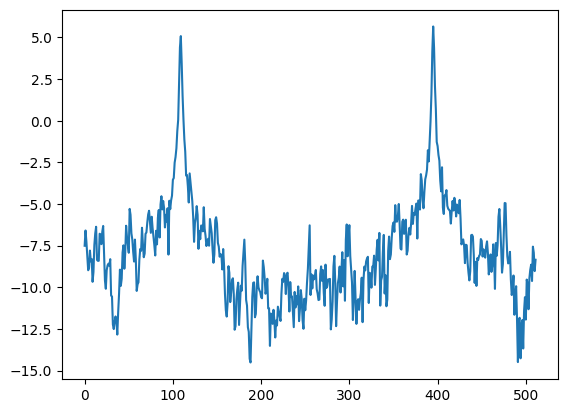

In [11]:
plt.figure()
plt.plot(tracks_logits_step[0,0,702,:].cpu())

#plt.figure()
#plt.plot(visible_logits_step.squeeze().squeeze().cpu())

In [16]:
num_frames = video_tensor_resized.shape[1]
output = {}

for track_id, trajectory in tqdm(track_histories.items()):
    coords = []
    for t in range(num_frames):
        step = next((pos for (frame, pos) in trajectory if frame == t), None)
        coords.append(step if step is not None else torch.tensor([float('nan'), float('nan')]))
    output[track_id] = torch.stack(coords)  # shape: [num_frames, 2]

output_list = [trajectory.unsqueeze(0) for _, trajectory in output.items()]
output_tensor = torch.cat(output_list, dim=0).unsqueeze(0).permute(0,2,1,3)  # shape: [1 , num_frames, num_feats, 2]

output_tensor = output_tensor[:,:,:,[1,0]]
output_tensor[:, : ,:,  :] *= torch.tensor([video[0].shape[1] / model_video_size[0], video[0].shape[0] / model_video_size[1]])

torch.cuda.empty_cache()

100%|██████████| 5371/5371 [00:03<00:00, 1771.22it/s]


In [20]:
frame_cut_out = output_tensor.shape[1]


# Calculate the number of visible frames for each track
visible_counts = torch.sum(~torch.isnan(output_tensor[0, :frame_cut_out, :, 0]), dim=0)

# Filter tracks that are visible for at least 20 frames
visible_tracks_mask = visible_counts >= 10
output_tensor_filtered = output_tensor[:, :frame_cut_out, visible_tracks_mask, :]
output_tensor_filtered.shape

torch.Size([1, 120, 4486, 2])

In [19]:
generate_frame_image_cv(video_tensor_original, output_tensor)

  0%|          | 0/120 [00:00<?, ?it/s]

100%|██████████| 120/120 [00:56<00:00,  2.11it/s]


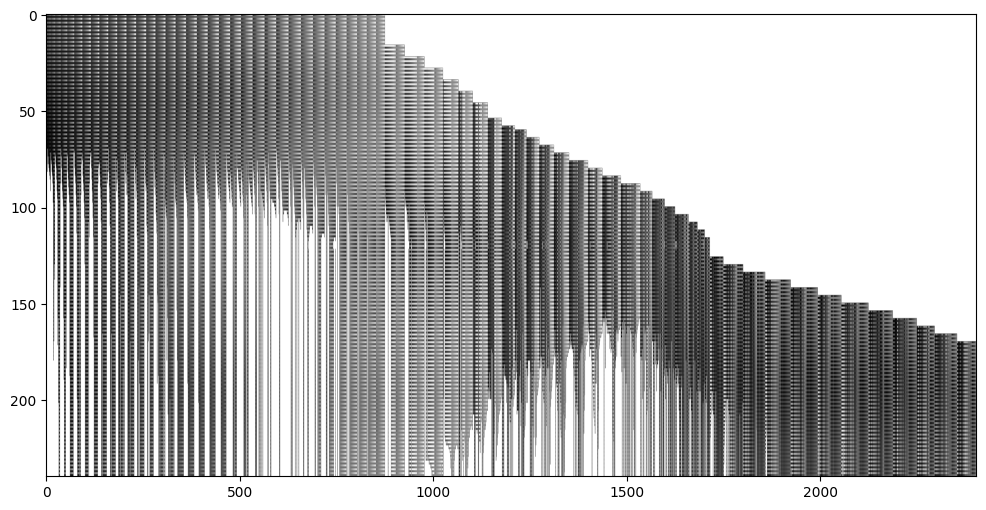

In [24]:
# Reshape the output_tensor to create the observation matrix
# Shape of output_tensor: [1, num_frames, num_feats, 2]
# Desired shape of observation_matrix: [feats*2, frames]

# todo: comparar halucinacao cotracker

obs_mat_full = np.zeros((output_tensor_filtered.shape[1] * 2, output_tensor_filtered.shape[2]), dtype=np.float32)
num_frames = output_tensor_filtered.shape[1]

for frame in range(output_tensor_filtered.shape[1]): # por frame
    obs_mat_full[frame*2, :] = output_tensor_filtered[0, frame, :, 0].cpu().numpy()  # x-coordinates
    obs_mat_full[frame*2+1, :] = output_tensor_filtered[0, frame, :, 1].cpu().numpy()  # y-coordinates

#remove columns (features) that have nan values
obs_mat = obs_mat_full[:, ~np.isnan(obs_mat_full).any(axis=0)]

# remove collumns that have more than 50% nan values
obs_mat_half_missed = obs_mat_full[:, np.sum(np.isnan(obs_mat_full), axis=0) < obs_mat_full.shape[0] / 1.4]

plt.figure(figsize=(12, 6))
plt.imshow(obs_mat_half_missed/np.nanmax(obs_mat_half_missed), aspect='auto', cmap='gray')
#plt.imshow(obs_mat_full, aspect='auto', cmap='gray', alpha=0.5)

100%|██████████| 100/100 [00:31<00:00,  3.14it/s, RMSE=5.997615814209]


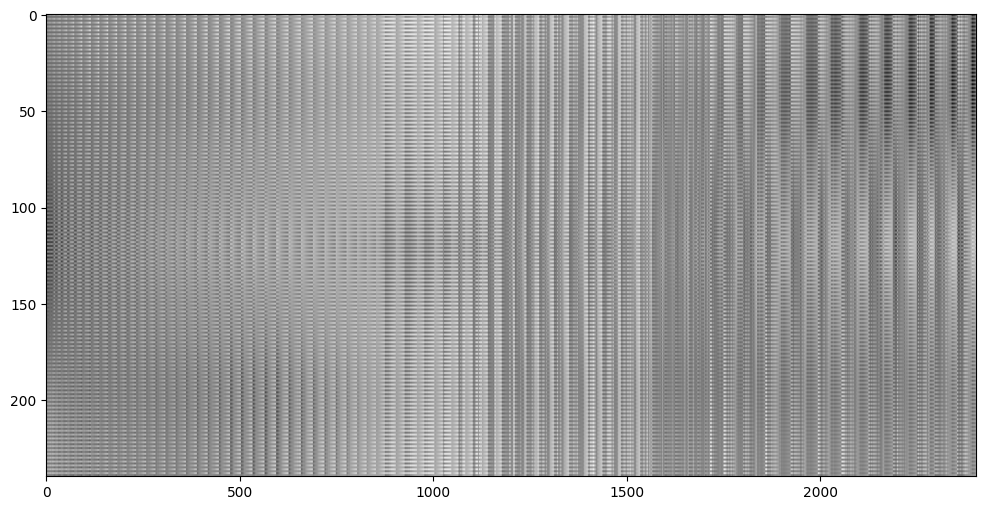

In [25]:
obs_completed, _ = alternating_matrix_completion(obs_mat_half_missed, mode=0, max_iters=100)

plt.figure(figsize=(12, 6))
plt.imshow(obs_completed/np.nanmax(obs_completed), aspect='auto', cmap='gray')

In [26]:

rr.init("factorization")
rr.notebook_show(width=int(1920*0.75), height=int(1080*0.75))

#rr.log("world/3d_shape", rr.Points3D(marques_factorization(obs_mat)[1].T))

rr.log("world/3d_completed", rr.Points3D(marques_factorization(obs_completed)[1].T))


# TODO: ADD COLOR TO EACH POINT


Viewer()